# Google Drive Connection

In [0]:
## Connecting google drive to colab

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 145113 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.17-0ubuntu2~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.17-0ubuntu2~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.17-0ubuntu2~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

# Imports

In [0]:
from __future__ import print_function
import math
import numpy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

%matplotlib inline
import matplotlib.pyplot as plt

!pip install torchsummary
from torchsummary import summary

# Model

In [0]:
#dropout_value = 0.05
class Net(nn.Module):
    def __init__(self, dropout_value):
        super(Net, self).__init__()

        self.dropout_value = dropout_value

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(self.dropout_value)
        ) # input_size = 28x28x1, output_size = 26x26x16, RF = 3x3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(24),
            nn.Dropout(self.dropout_value)
        ) # input_size = 26x26x16, output_size = 24x24x24, RF = 5x5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # input_size = 24x24x24, output_size = 24x24x10, RF = 5x5
        self.pool1 = nn.MaxPool2d(2, 2) # input_size = 24x24x10, output_size = 12x12x10, RF = 6x6

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14),
            nn.Dropout(self.dropout_value)
        ) # input_size = 12x12x10, output_size = 10x10x14, RF = 10x10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(self.dropout_value)
        ) # input_size = 10x10x14, output_size = 8x8x16, RF = 14x14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(self.dropout_value)
        ) # input_size = 8x8x16, output_size = 6x6x16, RF = 18x18
                
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # input_size = 6x6x16, output_size = 1x1x16, RF = 38x38

        # self.convblock7 = nn.Sequential(
        #     nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False)
        # ) # input_size = 1x1x16, output_size = 1x1x16, RF = 38x38
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) # input_size = 1x1x16, output_size = 1x1x10, RF = 38x38 


        #self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)        
        #x = self.convblock7(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Training Code


In [0]:
from tqdm import tqdm


def train(model, device, train_loader, optimizer, epoch, train_losses, train_acc, l1=False, lambda1=0.0005):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    
    # if L1 reg
    if l1:
      loss += L1_regularization(model, lambda1)

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


# Testing Code


In [0]:
def test(model, device, test_loader, test_losses, test_acc):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))


# Regularization Techniques (dropout, L1, L2, etc)


In [0]:
def L1_regularization(model, factor):
  reg_loss = 0
  for param in model.parameters():
    if param.dim() > 1:
      reg_loss += param.norm(1)
  loss = factor * reg_loss

  return loss


# Dataloader/Transformations/Image-augmentations


In [0]:
def generate_train_test_loader(SEED):
  # Train Phase transformations
  train_transforms = transforms.Compose([
                                        transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                                        #transforms.ColorJitter(brightness=0.2, contrast=0.2),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                        # Note the difference between (0.1307) and (0.1307,)
                                        ])

  # Test Phase transformations
  test_transforms = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.1307,), (0.3081,))
                                        ])

  train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
  test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  # CUDA?
  cuda = torch.cuda.is_available()

  # For reproducibility
  torch.manual_seed(SEED)

  if cuda:
      torch.cuda.manual_seed(SEED)

  # dataloader arguments - something you'll fetch these from cmdprmt
  dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

  # train dataloader
  train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

  # test dataloader
  test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

  return train_loader, test_loader, test


# Misc Items like finding misclassified images

In [0]:
# visualize accuracy and loss graph
def visualize_graph(train_losses, train_acc, test_losses, test_acc):
  fig, axs = plt.subplots(2,2,figsize=(15,10))
  axs[0, 0].plot(train_losses)
  axs[0, 0].set_title("Training Loss")
  axs[1, 0].plot(train_acc[4000:])
  axs[1, 0].set_title("Training Accuracy")
  axs[0, 1].plot(test_losses)
  axs[0, 1].set_title("Test Loss")
  axs[1, 1].plot(test_acc)
  axs[1, 1].set_title("Test Accuracy")

def set_device():
  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")

  return device

# view and save comparison graph of cal accuracy and loss
def visualize_save_comparison_graph(EPOCHS, dict_list, title, xlabel, ylabel, PATH, name="fig"):
  plt.figure(figsize=(20,10))
  epochs = range(1,EPOCHS+1)
  for label, item in dict_list.items():
    plt.plot(epochs, item, label=label)
  
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  plt.savefig(PATH+"/visualization/"+name+".png")

# view and save misclassified images
def show_save_misclassified_images(model, test_loader, name="fig", max_misclassified_imgs=25):
  cols = 5
  rows = math.ceil(max_misclassified_imgs / cols)
  
  with torch.no_grad():
    ind = 0
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      misclassified_imgs_pred = pred[pred.eq(target.view_as(pred))==False]
      
      misclassified_imgs_data = data[pred.eq(target.view_as(pred))==False]
      misclassified_imgs_target = target[(pred.eq(target.view_as(pred))==False).view_as(target)]
      if ind == 0:
        example_data, example_targets, example_preds = misclassified_imgs_data, misclassified_imgs_target, misclassified_imgs_pred
      elif example_data.shape[0] < max_misclassified_imgs:
        example_data = torch.cat([example_data, misclassified_imgs_data], dim=0)
        example_targets = torch.cat([example_targets, misclassified_imgs_target], dim=0)
        example_preds = torch.cat([example_preds, misclassified_imgs_pred], dim=0)
      else:
        break
      ind += 1
    example_data, example_targets, example_preds = example_data[:max_misclassified_imgs], example_targets[:max_misclassified_imgs], example_preds[:max_misclassified_imgs]

  fig = plt.figure(figsize=(20,10))
  for i in range(max_misclassified_imgs):
    plt.subplot(rows,cols,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i].cpu().numpy(), cmap='gray', interpolation='none')
    plt.title(f"{i+1}) Ground Truth: {example_targets[i]},\n Prediction: {example_preds[i]}")
    plt.xticks([])
    plt.yticks([])
  plt.savefig(PATH+"/visualization/"+name+".png")


# Execution(Run models for 40 epochs)

In [0]:
# google drive path for saving models, graphs and images
PATH = "drive/EVA4/Session6"

## Generating Data Loaders

In [0]:
SEED = 1
train_loader, test_loader, test_data = generate_train_test_loader(SEED)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


## 1) Without L1/L2

**************************************************
******************** Without L1/L2 Regularization ********************
**************************************************

 Initializing...
Creating model...


  0%|          | 0/469 [00:00<?, ?it/s]


 Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 24, 24, 24]           3,456
              ReLU-6           [-1, 24, 24, 24]               0
       BatchNorm2d-7           [-1, 24, 24, 24]              48
           Dropout-8           [-1, 24, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             240
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 14, 10, 10]           1,260
             ReLU-12           [-1, 14, 10, 10]               0
      BatchNorm2d-13           [-1, 14, 10, 10]              28
          Dropout-14  

Loss=0.07416483759880066 Batch_id=468 Accuracy=90.68: 100%|██████████| 469/469 [00:16<00:00, 27.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0504, Accuracy: 9846/10000 (98.46%)

EPOCH: 2


Loss=0.09154649823904037 Batch_id=468 Accuracy=97.08: 100%|██████████| 469/469 [00:16<00:00, 28.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0731, Accuracy: 9767/10000 (97.67%)

EPOCH: 3


Loss=0.0550544448196888 Batch_id=468 Accuracy=97.37: 100%|██████████| 469/469 [00:16<00:00, 28.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 9874/10000 (98.74%)

EPOCH: 4


Loss=0.11076843738555908 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:16<00:00, 27.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9900/10000 (99.00%)

EPOCH: 5


Loss=0.10161816328763962 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:17<00:00, 27.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0365, Accuracy: 9878/10000 (98.78%)

EPOCH: 6


Loss=0.19932174682617188 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:17<00:00, 27.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9916/10000 (99.16%)

EPOCH: 7


Loss=0.0701892077922821 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:16<00:00, 27.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9921/10000 (99.21%)

EPOCH: 8


Loss=0.049305837601423264 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:16<00:00, 28.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9931/10000 (99.31%)

EPOCH: 9


Loss=0.08652419596910477 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:17<00:00, 27.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9933/10000 (99.33%)

EPOCH: 10


Loss=0.0713202953338623 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:16<00:00, 27.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9937/10000 (99.37%)

EPOCH: 11


Loss=0.19303889572620392 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:16<00:00, 27.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9902/10000 (99.02%)

EPOCH: 12


Loss=0.03403710201382637 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:16<00:00, 27.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.040311723947525024 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:17<00:00, 27.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9924/10000 (99.24%)

EPOCH: 14


Loss=0.04294601082801819 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:16<00:00, 28.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9930/10000 (99.30%)

EPOCH: 15


Loss=0.12531931698322296 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:16<00:00, 27.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9929/10000 (99.29%)

EPOCH: 16


Loss=0.006563827395439148 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:16<00:00, 27.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9937/10000 (99.37%)

EPOCH: 17


Loss=0.09344858676195145 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:16<00:00, 28.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0175, Accuracy: 9944/10000 (99.44%)

EPOCH: 18


Loss=0.07492624968290329 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:16<00:00, 28.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9930/10000 (99.30%)

EPOCH: 19


Loss=0.008935242891311646 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:16<00:00, 33.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9935/10000 (99.35%)

EPOCH: 20


Loss=0.006503159645944834 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:16<00:00, 28.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9934/10000 (99.34%)

EPOCH: 21


Loss=0.012805342674255371 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:16<00:00, 28.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9943/10000 (99.43%)

EPOCH: 22


Loss=0.2011789083480835 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:16<00:00, 34.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9939/10000 (99.39%)

EPOCH: 23


Loss=0.011059711687266827 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:16<00:00, 28.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9930/10000 (99.30%)

EPOCH: 24


Loss=0.10956142097711563 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:16<00:00, 28.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9930/10000 (99.30%)

EPOCH: 25


Loss=0.03476582467556 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:16<00:00, 28.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9939/10000 (99.39%)

EPOCH: 26


Loss=0.07159470021724701 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:16<00:00, 28.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9933/10000 (99.33%)

EPOCH: 27


Loss=0.10807758569717407 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:16<00:00, 28.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9926/10000 (99.26%)

EPOCH: 28


Loss=0.023085057735443115 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:16<00:00, 28.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0178, Accuracy: 9946/10000 (99.46%)

EPOCH: 29


Loss=0.01129046082496643 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:16<00:00, 28.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9939/10000 (99.39%)

EPOCH: 30


Loss=0.009296576492488384 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:16<00:00, 27.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9938/10000 (99.38%)

EPOCH: 31


Loss=0.009050722233951092 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:17<00:00, 33.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9939/10000 (99.39%)

EPOCH: 32


Loss=0.007777546998113394 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:17<00:00, 27.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9946/10000 (99.46%)

EPOCH: 33


Loss=0.05797730013728142 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:17<00:00, 32.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9931/10000 (99.31%)

EPOCH: 34


Loss=0.018891682848334312 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:17<00:00, 26.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9921/10000 (99.21%)

EPOCH: 35


Loss=0.005340983625501394 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:16<00:00, 34.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0166, Accuracy: 9944/10000 (99.44%)

EPOCH: 36


Loss=0.042071565985679626 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:16<00:00, 34.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9941/10000 (99.41%)

EPOCH: 37


Loss=0.029645437374711037 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:16<00:00, 28.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0168, Accuracy: 9940/10000 (99.40%)

EPOCH: 38


Loss=0.03319545462727547 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:16<00:00, 28.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9955/10000 (99.55%)

EPOCH: 39


Loss=0.013348832726478577 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:16<00:00, 28.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9932/10000 (99.32%)

EPOCH: 40


Loss=0.021846160292625427 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:16<00:00, 27.71it/s]



Test set: Average loss: 0.0200, Accuracy: 9927/10000 (99.27%)


 Saving trained model...

 Visualizing:


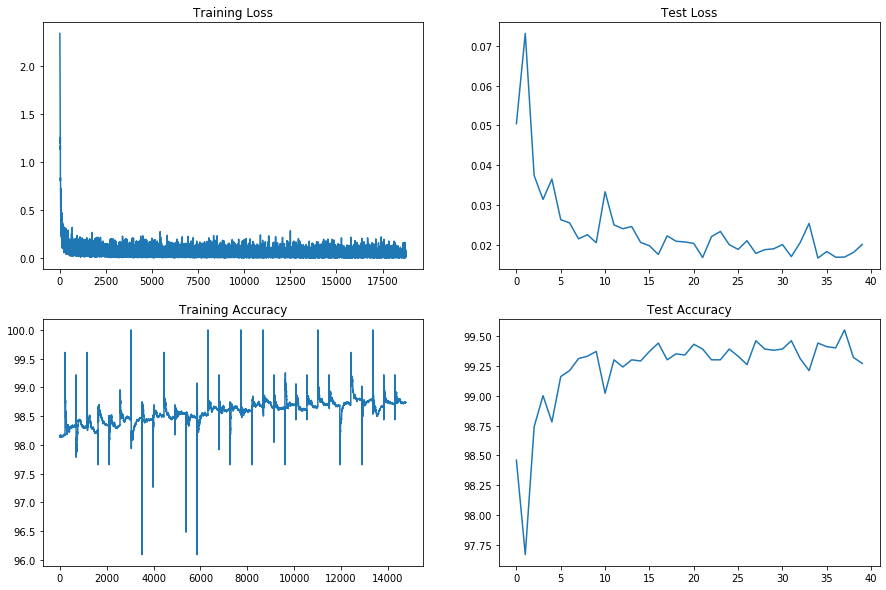

In [0]:
print("*"*50)
print("*"*20,"Without L1/L2 Regularization","*"*20)
print("*"*50)
print("\n Initializing...")
no_reg_train_losses = []
no_reg_test_losses = []
no_reg_train_acc = []
no_reg_test_acc = []
dropout_value = 0.05
LAMBDA1=0.0005
LR=0.1
MOMENTUM=0.9
inp_size = (1, 28, 28)
device = set_device()

print("Creating model...")
model =  Net(dropout_value).to(device)

print("\n Model Summary:")
summary(model, input_size=inp_size)
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)

print("\n Training the model...")
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch, no_reg_train_losses, no_reg_train_acc)
    test(model, device, test_loader, no_reg_test_losses, no_reg_test_acc)

print("\n Saving trained model...")
torch.save(model.state_dict(), PATH+"/models/model_dropout.pth")

print("\n Visualizing:")
visualize_graph(no_reg_train_losses, no_reg_train_acc, no_reg_test_losses, no_reg_test_acc)

## With L1

**************************************************
******************** With L1 Regularization ********************
**************************************************

 Initializing...


  0%|          | 0/469 [00:00<?, ?it/s]

Creating model...

 Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 24, 24, 24]           3,456
              ReLU-6           [-1, 24, 24, 24]               0
       BatchNorm2d-7           [-1, 24, 24, 24]              48
           Dropout-8           [-1, 24, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             240
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 14, 10, 10]           1,260
             ReLU-12           [-1, 14, 10, 10]               0
      BatchNorm2d-13           [-1, 14, 10, 10]              28
    

Loss=0.13977979123592377 Batch_id=468 Accuracy=89.64: 100%|██████████| 469/469 [00:17<00:00, 26.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0588, Accuracy: 9807/10000 (98.07%)

EPOCH: 2


Loss=0.1425928920507431 Batch_id=468 Accuracy=96.76: 100%|██████████| 469/469 [00:17<00:00, 26.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0400, Accuracy: 9856/10000 (98.56%)

EPOCH: 3


Loss=0.1106317862868309 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:17<00:00, 26.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Accuracy: 9859/10000 (98.59%)

EPOCH: 4


Loss=0.03778504207730293 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:16<00:00, 33.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Accuracy: 9905/10000 (99.05%)

EPOCH: 5


Loss=0.04180459678173065 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:16<00:00, 27.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0331, Accuracy: 9888/10000 (98.88%)

EPOCH: 6


Loss=0.08466506004333496 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:17<00:00, 27.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9899/10000 (98.99%)

EPOCH: 7


Loss=0.1553555727005005 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:17<00:00, 27.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9907/10000 (99.07%)

EPOCH: 8


Loss=0.052891239523887634 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:16<00:00, 28.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9908/10000 (99.08%)

EPOCH: 9


Loss=0.04854016751050949 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:16<00:00, 27.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9911/10000 (99.11%)

EPOCH: 10


Loss=0.05438685417175293 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:16<00:00, 28.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9919/10000 (99.19%)

EPOCH: 11


Loss=0.043665561825037 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:16<00:00, 28.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9928/10000 (99.28%)

EPOCH: 12


Loss=0.040293775498867035 Batch_id=468 Accuracy=98.24: 100%|██████████| 469/469 [00:16<00:00, 33.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9927/10000 (99.27%)

EPOCH: 13


Loss=0.08011626452207565 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:16<00:00, 28.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9912/10000 (99.12%)

EPOCH: 14


Loss=0.06510570645332336 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:16<00:00, 28.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9920/10000 (99.20%)

EPOCH: 15


Loss=0.12068746984004974 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:16<00:00, 27.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9922/10000 (99.22%)

EPOCH: 16


Loss=0.0680653527379036 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:16<00:00, 28.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9921/10000 (99.21%)

EPOCH: 17


Loss=0.056302525103092194 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:16<00:00, 28.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9924/10000 (99.24%)

EPOCH: 18


Loss=0.09232155978679657 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:16<00:00, 28.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9922/10000 (99.22%)

EPOCH: 19


Loss=0.0829513892531395 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:16<00:00, 28.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9931/10000 (99.31%)

EPOCH: 20


Loss=0.11694806069135666 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:16<00:00, 28.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9932/10000 (99.32%)

EPOCH: 21


Loss=0.049704812467098236 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:16<00:00, 28.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9939/10000 (99.39%)

EPOCH: 22


Loss=0.053686924278736115 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:16<00:00, 28.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9925/10000 (99.25%)

EPOCH: 23


Loss=0.16090993583202362 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:16<00:00, 28.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9925/10000 (99.25%)

EPOCH: 24


Loss=0.0669545829296112 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:17<00:00, 26.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9931/10000 (99.31%)

EPOCH: 25


Loss=0.08199019730091095 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:17<00:00, 26.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9935/10000 (99.35%)

EPOCH: 26


Loss=0.048586245626211166 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:17<00:00, 26.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9938/10000 (99.38%)

EPOCH: 27


Loss=0.04017386585474014 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:16<00:00, 27.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9921/10000 (99.21%)

EPOCH: 28


Loss=0.11485229432582855 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:17<00:00, 27.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9925/10000 (99.25%)

EPOCH: 29


Loss=0.05245034024119377 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:16<00:00, 27.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9939/10000 (99.39%)

EPOCH: 30


Loss=0.06536777317523956 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:16<00:00, 28.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9940/10000 (99.40%)

EPOCH: 31


Loss=0.034552156925201416 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:16<00:00, 32.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9937/10000 (99.37%)

EPOCH: 32


Loss=0.04164866358041763 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:16<00:00, 28.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9915/10000 (99.15%)

EPOCH: 33


Loss=0.16495776176452637 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:16<00:00, 27.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9935/10000 (99.35%)

EPOCH: 34


Loss=0.07330326735973358 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:16<00:00, 28.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9936/10000 (99.36%)

EPOCH: 35


Loss=0.04834640771150589 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:17<00:00, 27.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9935/10000 (99.35%)

EPOCH: 36


Loss=0.03005819395184517 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:16<00:00, 27.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9934/10000 (99.34%)

EPOCH: 37


Loss=0.029114767909049988 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:16<00:00, 27.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9940/10000 (99.40%)

EPOCH: 38


Loss=0.04852106422185898 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:17<00:00, 27.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9934/10000 (99.34%)

EPOCH: 39


Loss=0.06536932289600372 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:16<00:00, 27.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9938/10000 (99.38%)

EPOCH: 40


Loss=0.08496469259262085 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:16<00:00, 28.06it/s]



Test set: Average loss: 0.0186, Accuracy: 9946/10000 (99.46%)


 Saving trained model...

 Visualizing:


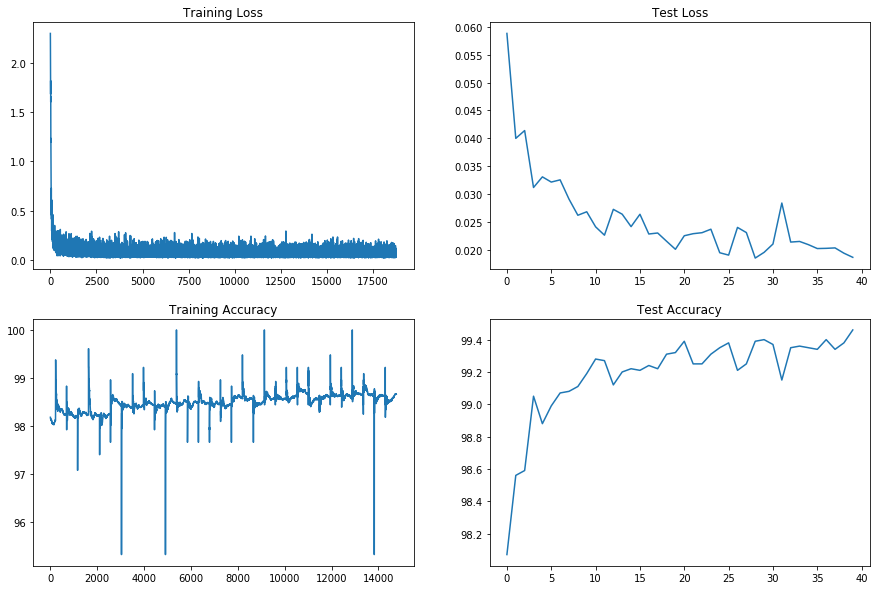

In [0]:
print("*"*50)
print("*"*20,"With L1 Regularization","*"*20)
print("*"*50)
print("\n Initializing...")
l1_reg_train_losses = []
l1_reg_test_losses = []
l1_reg_train_acc = []
l1_reg_test_acc = []
dropout_value = 0.05
LAMBDA1=1e-5
LR=0.1
MOMENTUM=0.9
inp_size = (1, 28, 28)
device = set_device()

print("Creating model...")
l1_model =  Net(dropout_value).to(device)

print("\n Model Summary:")
summary(l1_model, input_size=inp_size)
optimizer = optim.SGD(l1_model.parameters(), lr=LR, momentum=MOMENTUM)

print("\n Training the model...")
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(l1_model, device, train_loader, optimizer, epoch, l1_reg_train_losses, l1_reg_train_acc, l1=True, lambda1=LAMBDA1)
    test(l1_model, device, test_loader, l1_reg_test_losses, l1_reg_test_acc)

print("\n Saving trained model...")
torch.save(l1_model.state_dict(), PATH+"/models/model_l1.pth")

print("\n Visualizing:")
visualize_graph(l1_reg_train_losses, l1_reg_train_acc, l1_reg_test_losses, l1_reg_test_acc)

## 3) With L2

  0%|          | 0/469 [00:00<?, ?it/s]

**************************************************
******************** With L2 Regularization ********************
**************************************************

 Initializing...
Creating model...

 Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 24, 24, 24]           3,456
              ReLU-6           [-1, 24, 24, 24]               0
       BatchNorm2d-7           [-1, 24, 24, 24]              48
           Dropout-8           [-1, 24, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             240
        MaxPool2d-10           [-1, 10, 12, 12]               0
           

Loss=0.010398507118225098 Batch_id=468 Accuracy=90.81: 100%|██████████| 469/469 [00:15<00:00, 29.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0414, Accuracy: 9871/10000 (98.71%)

EPOCH: 2


Loss=0.08477532863616943 Batch_id=468 Accuracy=97.00: 100%|██████████| 469/469 [00:16<00:00, 29.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9887/10000 (98.87%)

EPOCH: 3


Loss=0.07146706432104111 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:15<00:00, 29.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9899/10000 (98.99%)

EPOCH: 4


Loss=0.044026006013154984 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:16<00:00, 29.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9911/10000 (99.11%)

EPOCH: 5


Loss=0.019626611843705177 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:15<00:00, 29.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9904/10000 (99.04%)

EPOCH: 6


Loss=0.05247396230697632 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:15<00:00, 29.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9902/10000 (99.02%)

EPOCH: 7


Loss=0.08326292783021927 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:15<00:00, 35.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9892/10000 (98.92%)

EPOCH: 8


Loss=0.02550181932747364 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:15<00:00, 29.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9936/10000 (99.36%)

EPOCH: 9


Loss=0.018157193437218666 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:16<00:00, 28.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9935/10000 (99.35%)

EPOCH: 10


Loss=0.036277055740356445 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:16<00:00, 36.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9919/10000 (99.19%)

EPOCH: 11


Loss=0.14534668624401093 Batch_id=468 Accuracy=98.30: 100%|██████████| 469/469 [00:15<00:00, 37.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9924/10000 (99.24%)

EPOCH: 12


Loss=0.08561432361602783 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:16<00:00, 29.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9921/10000 (99.21%)

EPOCH: 13


Loss=0.11687757819890976 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:15<00:00, 29.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9921/10000 (99.21%)

EPOCH: 14


Loss=0.00852514524012804 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:16<00:00, 28.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9932/10000 (99.32%)

EPOCH: 15


Loss=0.046576764434576035 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:15<00:00, 29.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9930/10000 (99.30%)

EPOCH: 16


Loss=0.0093694431707263 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:16<00:00, 29.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9929/10000 (99.29%)

EPOCH: 17


Loss=0.01745041273534298 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:16<00:00, 29.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9917/10000 (99.17%)

EPOCH: 18


Loss=0.070047527551651 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:16<00:00, 29.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9931/10000 (99.31%)

EPOCH: 19


Loss=0.04443705081939697 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:16<00:00, 28.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9934/10000 (99.34%)

EPOCH: 20


Loss=0.18262772262096405 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:15<00:00, 29.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9921/10000 (99.21%)

EPOCH: 21


Loss=0.06871894001960754 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:16<00:00, 28.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9931/10000 (99.31%)

EPOCH: 22


Loss=0.06707227230072021 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:16<00:00, 29.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9929/10000 (99.29%)

EPOCH: 23


Loss=0.1453334540128708 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:16<00:00, 29.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9948/10000 (99.48%)

EPOCH: 24


Loss=0.05487009882926941 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:16<00:00, 28.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9931/10000 (99.31%)

EPOCH: 25


Loss=0.12560348212718964 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:16<00:00, 29.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9933/10000 (99.33%)

EPOCH: 26


Loss=0.036813389509916306 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:16<00:00, 28.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9931/10000 (99.31%)

EPOCH: 27


Loss=0.0220333281904459 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:16<00:00, 28.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9929/10000 (99.29%)

EPOCH: 28


Loss=0.10335583239793777 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:16<00:00, 28.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9936/10000 (99.36%)

EPOCH: 29


Loss=0.05756925046443939 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:16<00:00, 28.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9937/10000 (99.37%)

EPOCH: 30


Loss=0.019433708861470222 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:15<00:00, 29.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9932/10000 (99.32%)

EPOCH: 31


Loss=0.017427319660782814 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:16<00:00, 29.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9934/10000 (99.34%)

EPOCH: 32


Loss=0.02653755433857441 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:15<00:00, 29.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9942/10000 (99.42%)

EPOCH: 33


Loss=0.0429396778345108 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:15<00:00, 29.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9940/10000 (99.40%)

EPOCH: 34


Loss=0.014184643514454365 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:15<00:00, 30.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9935/10000 (99.35%)

EPOCH: 35


Loss=0.06387598812580109 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:15<00:00, 30.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0190, Accuracy: 9937/10000 (99.37%)

EPOCH: 36


Loss=0.01692676544189453 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:15<00:00, 29.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9934/10000 (99.34%)

EPOCH: 37


Loss=0.09980543702840805 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:15<00:00, 30.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9937/10000 (99.37%)

EPOCH: 38


Loss=0.02058170922100544 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:15<00:00, 30.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9943/10000 (99.43%)

EPOCH: 39


Loss=0.04376077279448509 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:15<00:00, 30.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9939/10000 (99.39%)

EPOCH: 40


Loss=0.005748992320150137 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:15<00:00, 30.40it/s]



Test set: Average loss: 0.0191, Accuracy: 9932/10000 (99.32%)


 Saving trained model...

 Visualizing:


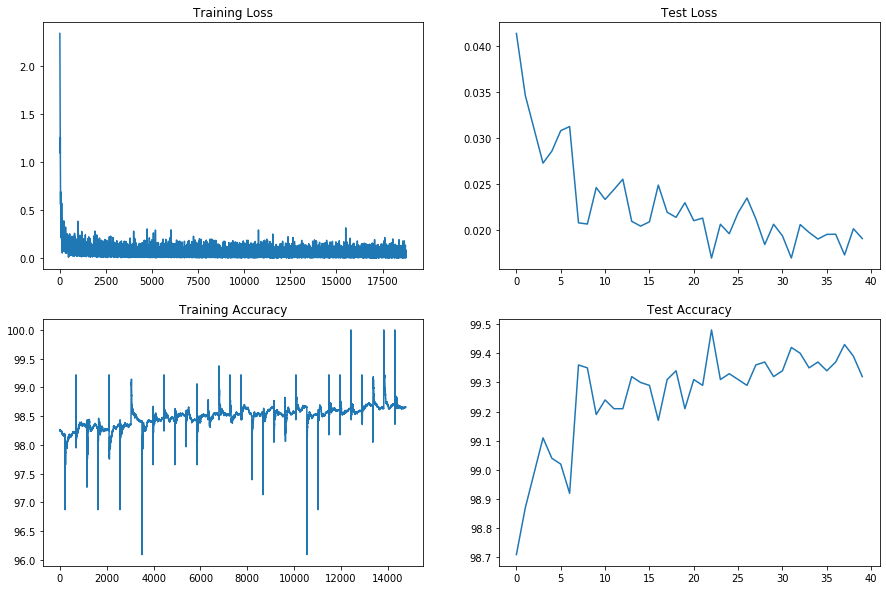

In [0]:
print("*"*50)
print("*"*20,"With L2 Regularization","*"*20)
print("*"*50)
print("\n Initializing...")
l2_reg_train_losses = []
l2_reg_test_losses = []
l2_reg_train_acc = []
l2_reg_test_acc = []
dropout_value = 0.05
LR=0.1
MOMENTUM=0.9
WEIGHT_DECAY=1e-5
inp_size = (1, 28, 28)
device = set_device()

print("Creating model...")
l2_model =  Net(dropout_value).to(device)

print("\n Model Summary:")
summary(l2_model, input_size=inp_size)
optimizer = optim.SGD(l2_model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

print("\n Training the model...")
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(l2_model, device, train_loader, optimizer, epoch, l2_reg_train_losses, l2_reg_train_acc)
    test(l2_model, device, test_loader, l2_reg_test_losses, l2_reg_test_acc)

print("\n Saving trained model...")
torch.save(l2_model.state_dict(), PATH+"/models/model_l2.pth")

print("\n Visualizing:")
visualize_graph(l2_reg_train_losses, l2_reg_train_acc, l2_reg_test_losses, l2_reg_test_acc)

## 4) With L1 and L2

**************************************************
******************** With L1 and L2 Regularization ********************
**************************************************

 Initializing...


  0%|          | 0/469 [00:00<?, ?it/s]

Creating model...

 Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 24, 24, 24]           3,456
              ReLU-6           [-1, 24, 24, 24]               0
       BatchNorm2d-7           [-1, 24, 24, 24]              48
           Dropout-8           [-1, 24, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             240
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 14, 10, 10]           1,260
             ReLU-12           [-1, 14, 10, 10]               0
      BatchNorm2d-13           [-1, 14, 10, 10]              28
    

Loss=0.20734789967536926 Batch_id=468 Accuracy=81.57: 100%|██████████| 469/469 [00:17<00:00, 26.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0691, Accuracy: 9835/10000 (98.35%)

EPOCH: 2


Loss=0.20144610106945038 Batch_id=468 Accuracy=96.02: 100%|██████████| 469/469 [00:17<00:00, 27.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0489, Accuracy: 9865/10000 (98.65%)

EPOCH: 3


Loss=0.0791238322854042 Batch_id=468 Accuracy=96.85: 100%|██████████| 469/469 [00:17<00:00, 27.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0410, Accuracy: 9884/10000 (98.84%)

EPOCH: 4


Loss=0.14228154718875885 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:17<00:00, 27.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 9890/10000 (98.90%)

EPOCH: 5


Loss=0.047470543533563614 Batch_id=468 Accuracy=97.53: 100%|██████████| 469/469 [00:16<00:00, 27.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9910/10000 (99.10%)

EPOCH: 6


Loss=0.13017374277114868 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:16<00:00, 27.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9909/10000 (99.09%)

EPOCH: 7


Loss=0.07799076288938522 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:16<00:00, 31.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9904/10000 (99.04%)

EPOCH: 8


Loss=0.030625153332948685 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:16<00:00, 27.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Loss=0.08783900737762451 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:16<00:00, 27.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9927/10000 (99.27%)

EPOCH: 10


Loss=0.02374882809817791 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:16<00:00, 28.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9912/10000 (99.12%)

EPOCH: 11


Loss=0.06856611371040344 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:17<00:00, 27.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9918/10000 (99.18%)

EPOCH: 12


Loss=0.01806839555501938 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:16<00:00, 28.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9931/10000 (99.31%)

EPOCH: 13


Loss=0.08620312809944153 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:16<00:00, 28.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.02928815968334675 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:16<00:00, 27.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9933/10000 (99.33%)

EPOCH: 15


Loss=0.12406449764966965 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:16<00:00, 28.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9925/10000 (99.25%)

EPOCH: 16


Loss=0.11436902731657028 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:16<00:00, 28.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9935/10000 (99.35%)

EPOCH: 17


Loss=0.045027099549770355 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:16<00:00, 27.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9926/10000 (99.26%)

EPOCH: 18


Loss=0.13139647245407104 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:16<00:00, 28.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9929/10000 (99.29%)

EPOCH: 19


Loss=0.0627368614077568 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:16<00:00, 28.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9937/10000 (99.37%)

EPOCH: 20


Loss=0.19839410483837128 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:16<00:00, 28.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9938/10000 (99.38%)

EPOCH: 21


Loss=0.01896267756819725 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:16<00:00, 28.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9941/10000 (99.41%)

EPOCH: 22


Loss=0.0308026485145092 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:16<00:00, 28.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9930/10000 (99.30%)

EPOCH: 23


Loss=0.05790039896965027 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:16<00:00, 28.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9937/10000 (99.37%)

EPOCH: 24


Loss=0.022202234715223312 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:17<00:00, 26.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9946/10000 (99.46%)

EPOCH: 25


Loss=0.06916515529155731 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:16<00:00, 28.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9925/10000 (99.25%)

EPOCH: 26


Loss=0.026727814227342606 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:16<00:00, 27.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9931/10000 (99.31%)

EPOCH: 27


Loss=0.052653588354587555 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:17<00:00, 26.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9937/10000 (99.37%)

EPOCH: 28


Loss=0.036331623792648315 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:17<00:00, 27.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9938/10000 (99.38%)

EPOCH: 29


Loss=0.017871059477329254 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:17<00:00, 27.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9940/10000 (99.40%)

EPOCH: 30


Loss=0.09458521008491516 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:17<00:00, 31.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9944/10000 (99.44%)

EPOCH: 31


Loss=0.021501019597053528 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:17<00:00, 27.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9943/10000 (99.43%)

EPOCH: 32


Loss=0.03194963186979294 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:17<00:00, 31.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9935/10000 (99.35%)

EPOCH: 33


Loss=0.04518020898103714 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:17<00:00, 26.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9932/10000 (99.32%)

EPOCH: 34


Loss=0.025830715894699097 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:16<00:00, 27.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9930/10000 (99.30%)

EPOCH: 35


Loss=0.05722884088754654 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:17<00:00, 27.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9938/10000 (99.38%)

EPOCH: 36


Loss=0.13124485313892365 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:16<00:00, 28.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0185, Accuracy: 9944/10000 (99.44%)

EPOCH: 37


Loss=0.08535090833902359 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:16<00:00, 33.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9945/10000 (99.45%)

EPOCH: 38


Loss=0.0547739714384079 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:16<00:00, 28.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9936/10000 (99.36%)

EPOCH: 39


Loss=0.08216449618339539 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:16<00:00, 28.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Accuracy: 9937/10000 (99.37%)

EPOCH: 40


Loss=0.05152588337659836 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:16<00:00, 27.65it/s]



Test set: Average loss: 0.0180, Accuracy: 9950/10000 (99.50%)


 Saving trained model...

 Visualizing:


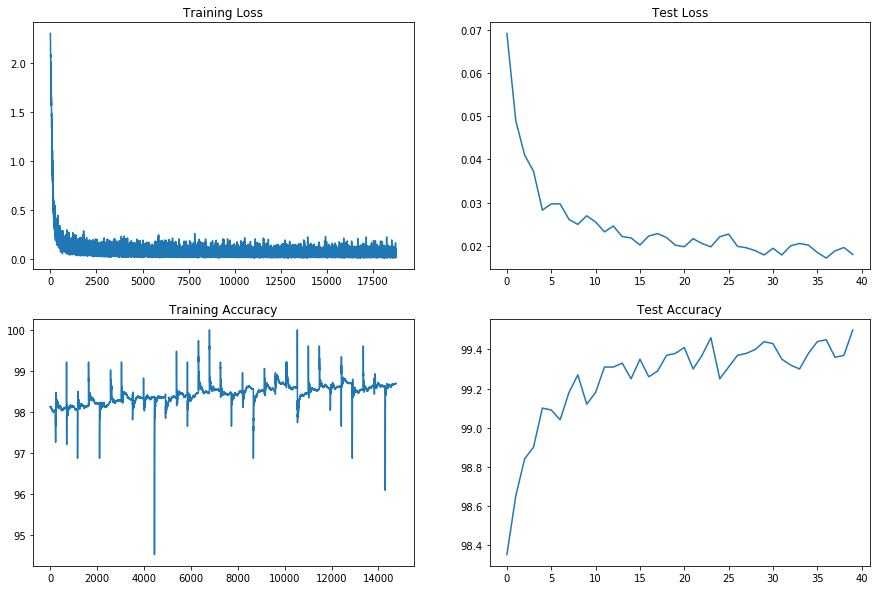

In [0]:
print("*"*50)
print("*"*20,"With L1 and L2 Regularization","*"*20)
print("*"*50)
print("\n Initializing...")
l1_l2_reg_train_losses = []
l1_l2_reg_test_losses = []
l1_l2_reg_train_acc = []
l1_l2_reg_test_acc = []
dropout_value = 0.05
LAMBDA1=1e-5
LR=0.01
MOMENTUM=0.9
WEIGHT_DECAY=1e-5
inp_size = (1, 28, 28)
device = set_device()

print("Creating model...")
l1_l2_model =  Net(dropout_value).to(device)

print("\n Model Summary:")
summary(l1_l2_model, input_size=inp_size)
optimizer = optim.SGD(l1_l2_model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

print("\n Training the model...")
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(l1_l2_model, device, train_loader, optimizer, epoch, l1_l2_reg_train_losses, l1_l2_reg_train_acc, l1=True, lambda1=LAMBDA1)
    test(l1_l2_model, device, test_loader, l1_l2_reg_test_losses, l1_l2_reg_test_acc)

print("\n Saving trained model...")
torch.save(l1_l2_model.state_dict(), PATH+"/models/model_l1_l2.pth")

print("\n Visualizing:")
visualize_graph(l1_l2_reg_train_losses, l1_l2_reg_train_acc, l1_l2_reg_test_losses, l1_l2_reg_test_acc)

# Visualising comparison graphs

In [0]:
EPOCHS = 40
acc_dict_list = {'Dropout': no_reg_test_acc, 'Dropout and L1 Reg': l1_reg_test_acc, 'Dropout and L2 Reg': l2_reg_test_acc, 'Dropout, L1 and L2 Reg': l1_l2_reg_test_acc}

loss_dict_list = {'Dropout': no_reg_test_losses, 'Dropout and L1 Reg': l1_reg_test_losses, 'Dropout and L2 Reg': l2_reg_test_losses, 'Dropout, L1 and L2 Reg': l1_l2_reg_test_losses}

In [0]:
import json
with open(PATH+'/acc_loss_data/acc.json', 'w') as fp:
    json.dump(acc_dict_list, fp)

with open(PATH+'/acc_loss_data/loss.json', 'w') as fp:
    json.dump(loss_dict_list, fp)

## 1) Validation Accuracy

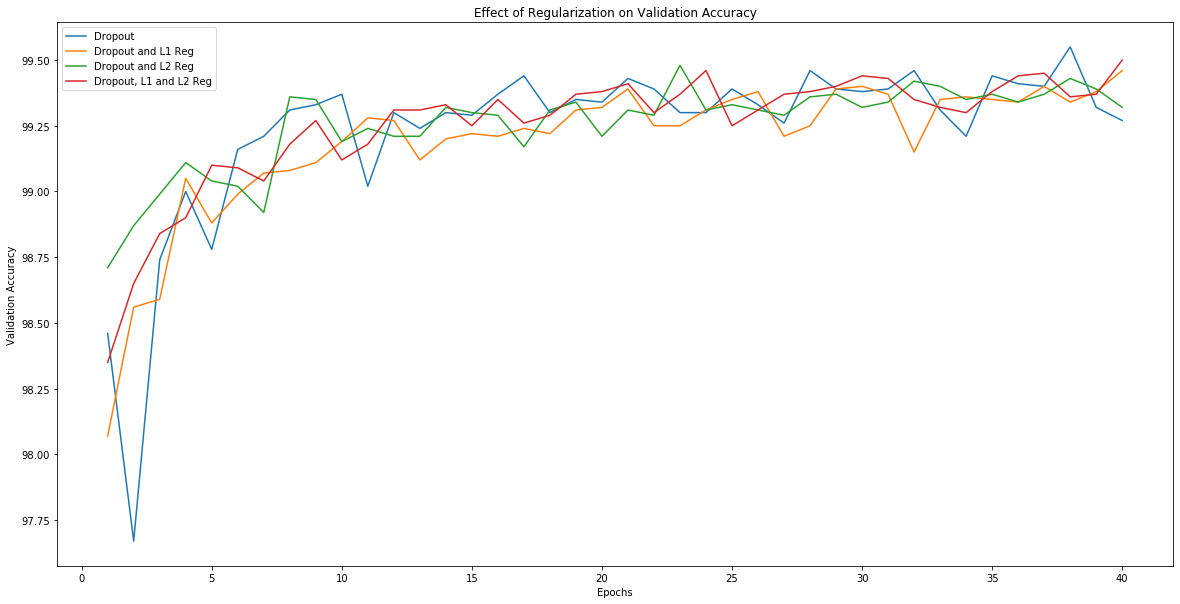

In [0]:
title, xlabel, ylabel = 'Effect of Regularization on Validation Accuracy', 'Epochs', 'Validation Accuracy'
visualize_save_comparison_graph(EPOCHS, acc_dict_list, title, xlabel, ylabel, PATH, name="val_acc_comparison")

## 2) Validation Loss

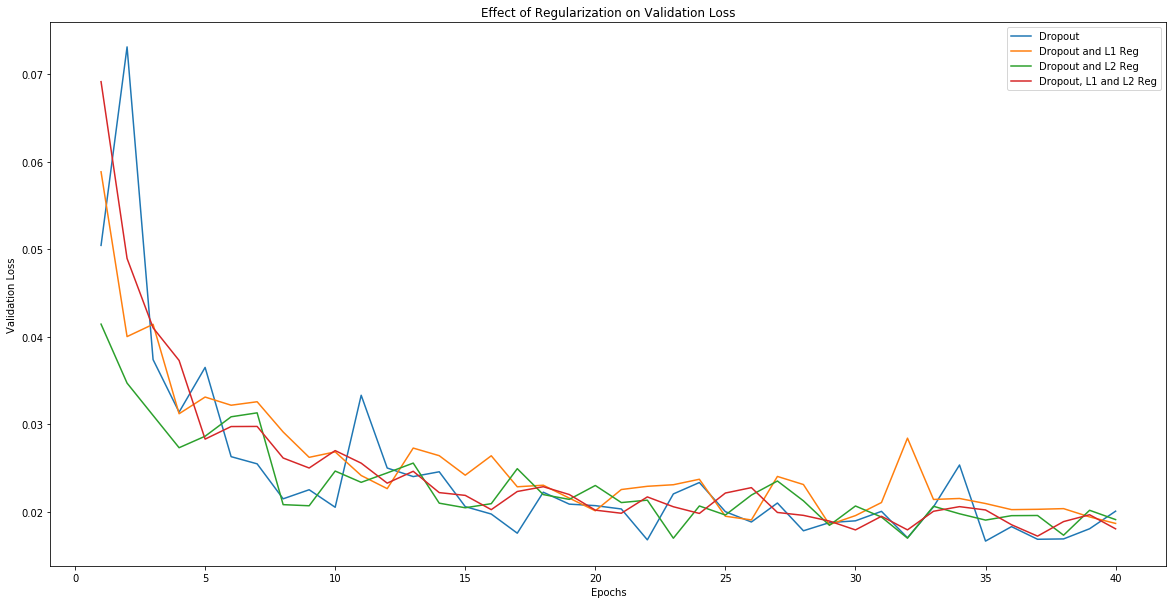

In [0]:
title, xlabel, ylabel = 'Effect of Regularization on Validation Loss', 'Epochs', 'Validation Loss'
visualize_save_comparison_graph(EPOCHS, loss_dict_list, title, xlabel, ylabel, PATH, name="val_loss_comparison")

# Visualize 25 Misclassified Images for L1 and L2 models

## 1) Without L1/L2

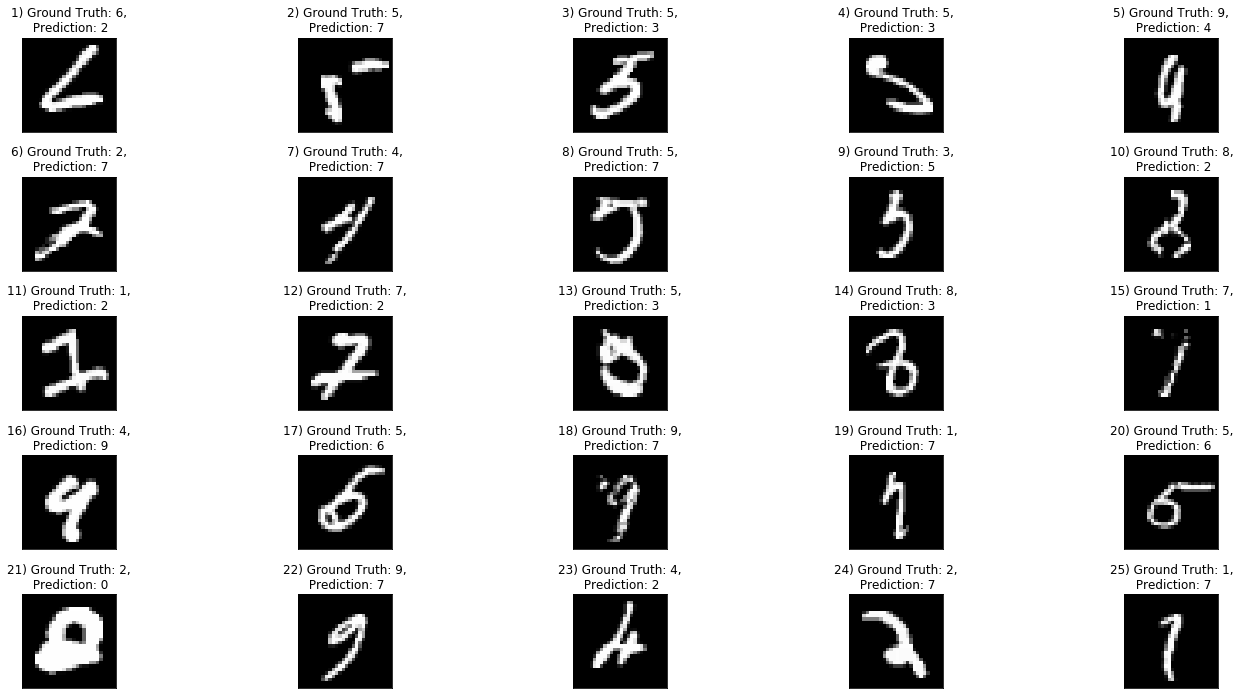

In [0]:
show_save_misclassified_images(model, test_loader, name="no_l1_l2_misclassified_images", max_misclassified_imgs=25)

## 2) For L1

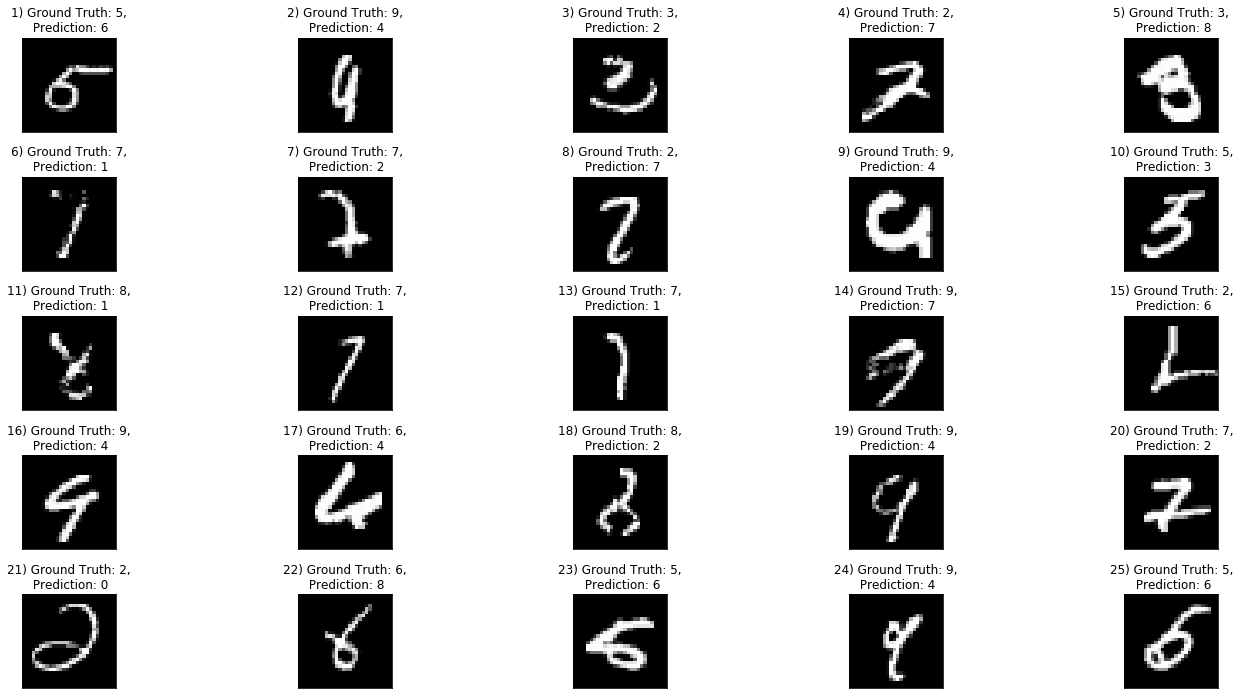

In [0]:
show_save_misclassified_images(l1_model, test_loader, name="l1_misclassified_images", max_misclassified_imgs=25)

## 3) For L2

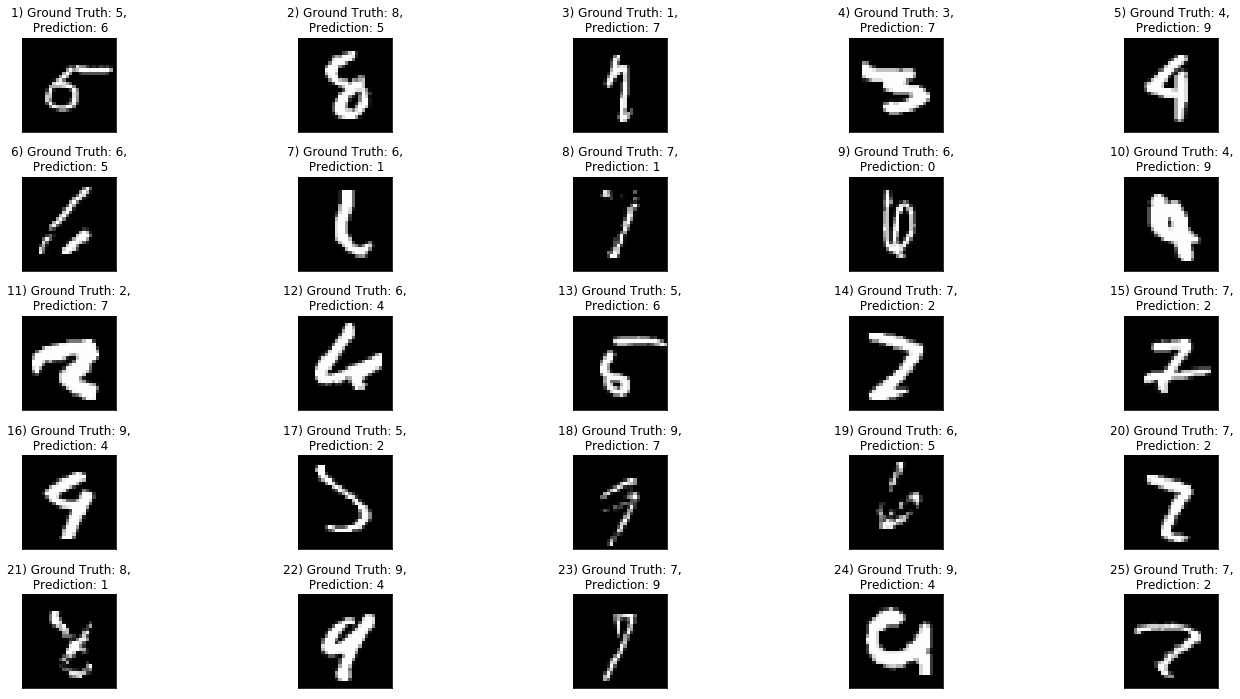

In [0]:
show_save_misclassified_images(l2_model, test_loader, name="l2_misclassified_images", max_misclassified_imgs=25)

## 4) For L1 and L2

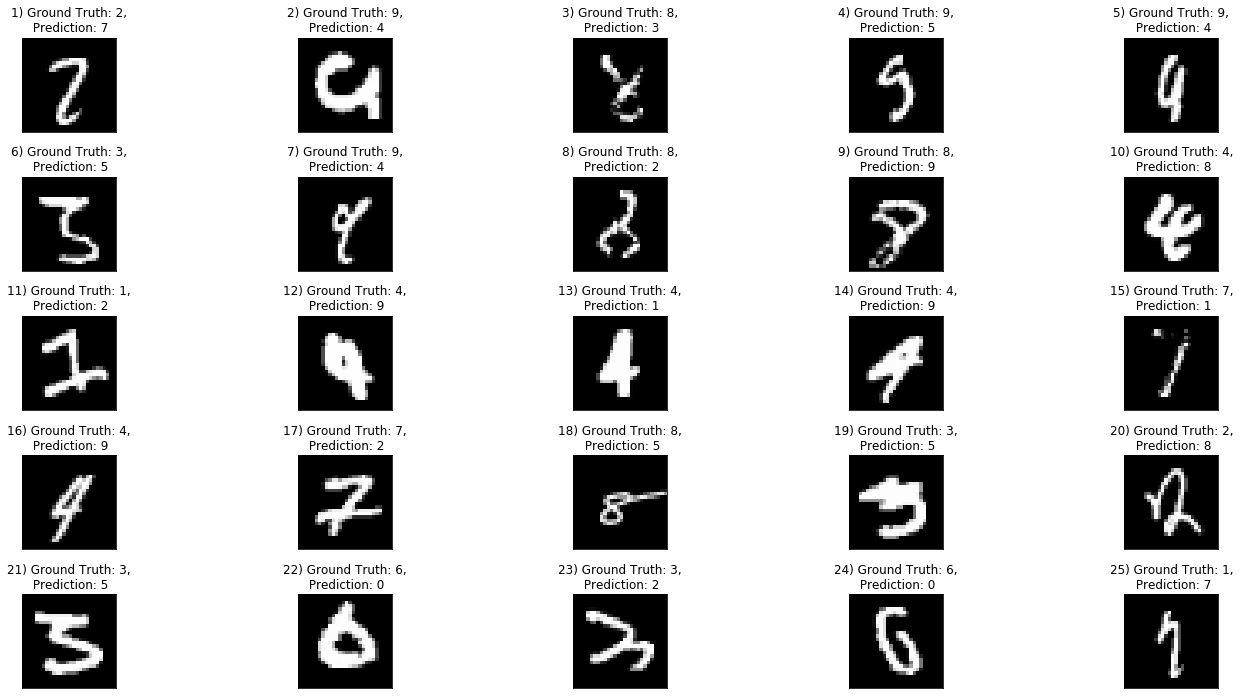

In [0]:
show_save_misclassified_images(l1_l2_model, test_loader, name="l1_l2_misclassified_images", max_misclassified_imgs=25)

# Observations
---

![alt text](https://raw.githubusercontent.com/genigarus/EVA4/master/S6/Assets/visualization/val_loss_comparison.png)

1) From the validation loss comparison graph, we can see that adding any regularization L1(with lambda=1e-5) or L2(with decay rate=1e-5) smoothes out the loss curve by penalizing the weights. L2 starts showing lower loss value sooner in comparison to L1. Thus, for smaller number of epochs L2 would seem to work better. But, as we increase the number of epochs, both regularization show comparable results. For higher values of lambda in L1 regularization, validation loss is high as compared to without L1 regularization because the weights are penalized heavily taking into consideration the fact that the model is already quite small and simple. L1 and L2 regularization together makes the loss curve smoother and takes to a lower final loss value in comparison to all the four.


2) From misclassified images, we can see that the network confuses a lot between 7 and 2. Half written digits also confuses the network a lot.